# Explore NOAA GEFSv12 Reforecast data
This notebook explores ways to fetch and read the Grib2 format of these files.  My preference is to use xarray but there are some quirks in the data that required non-standard methods of reading.  For example using the automatic filtering function of cfgrib (grib engine in xarray) https://github.com/ecmwf/cfgrib#automatic-filtering

## Data located on amazon aws
* https://noaa-gefs-retrospective.s3.amazonaws.com/index.html

In [1]:
import urllib.request
import requests

In [2]:
# URL of AWS S3 Explorer: https://noaa-gefs-retrospective.s3.amazonaws.com/index.html#GEFSv12/reforecast/2000/2000010200/c00/Days:1-10/
url = 'https://noaa-gefs-retrospective.s3.amazonaws.com/GEFSv12/reforecast/2000/2000010100/c00/Days:1-10/tmin_2m_2000010100_c00.grib2'
# Using urllib
urllib.request.urlretrieve(url, 'urllib_tmin_2m_2000010100_c00.grib2')
# Using requests
r = requests.get(url)
with open('tmin_2m_2000010100_c00.grib2', 'wb') as f:
    f.write(r.content)

In [3]:
print(r.status_code)
print(r.headers['content-type'])
print(r.encoding)

200
binary/octet-stream
None


In [4]:
import xarray as xr
import matplotlib.pyplot as plt
import pygrib

grbs = pygrib.open('tmin_2m_2000010100_c00.grib2')

In [5]:
#print inventory
grbs.seek(0)
for index,g in enumerate(grbs):
#     if index <= 2:
#         print(g)
    print(g.typeOfLevel, g.level, g.name, g.validDate, g.analDate, g.forecastTime, g.hourOfEndOfOverallTimeInterval, g.timeIncrement, g.isHindcast)
print(g.keys())

heightAboveGround 2 Minimum temperature 2000-01-01 00:00:00 2000-01-01 00:00:00 0 3 0 0
heightAboveGround 2 Minimum temperature 2000-01-01 00:00:00 2000-01-01 00:00:00 0 6 0 0
heightAboveGround 2 Minimum temperature 2000-01-01 06:00:00 2000-01-01 00:00:00 6 9 0 0
heightAboveGround 2 Minimum temperature 2000-01-01 06:00:00 2000-01-01 00:00:00 6 12 0 0
heightAboveGround 2 Minimum temperature 2000-01-01 12:00:00 2000-01-01 00:00:00 12 15 0 0
heightAboveGround 2 Minimum temperature 2000-01-01 12:00:00 2000-01-01 00:00:00 12 18 0 0
heightAboveGround 2 Minimum temperature 2000-01-01 18:00:00 2000-01-01 00:00:00 18 21 0 0
heightAboveGround 2 Minimum temperature 2000-01-01 18:00:00 2000-01-01 00:00:00 18 0 0 0
heightAboveGround 2 Minimum temperature 2000-01-02 00:00:00 2000-01-01 00:00:00 24 3 0 0
heightAboveGround 2 Minimum temperature 2000-01-02 00:00:00 2000-01-01 00:00:00 24 6 0 0
heightAboveGround 2 Minimum temperature 2000-01-02 06:00:00 2000-01-01 00:00:00 30 9 0 0
heightAboveGround 2 M

In [6]:
ds = xr.open_dataset('tmin_2m_2000010100_c00.grib2', engine='cfgrib')#, backend_kwargs={'filter_by_keys':{'fcst time': 3}})
# ds = xr.open_dataset('tmin_2m_2000010100_c00.grib2', engine='cfgrib', backend_kwargs={filter_by_keys:{'totalNumber': 2}})

Ignoring index file '/home/rmcd/git/S2S_Explore/notebooks/tmin_2m_2000010100_c00.grib2.90c91.idx' older than GRIB file


DatasetBuildError: multiple values for unique key, try re-open the file with one of:
    filter_by_keys={'totalNumber': 20}
    filter_by_keys={'totalNumber': 10}

In [7]:
import cfgrib
cfg_ds = cfgrib.open_datasets('tmin_2m_2000010100_c00.grib2')
cfg_ds


Ignoring index file 'tmin_2m_2000010100_c00.grib2.90c91.idx' older than GRIB file
Ignoring index file '/home/rmcd/git/S2S_Explore/notebooks/tmin_2m_2000010100_c00.grib2.90c91.idx' older than GRIB file
Ignoring index file '/home/rmcd/git/S2S_Explore/notebooks/tmin_2m_2000010100_c00.grib2.90c91.idx' older than GRIB file
Ignoring index file '/home/rmcd/git/S2S_Explore/notebooks/tmin_2m_2000010100_c00.grib2.90c91.idx' older than GRIB file


[<xarray.Dataset>
 Dimensions:            (latitude: 721, longitude: 1440, step: 2)
 Coordinates:
     number             int64 0
     time               datetime64[ns] 2000-01-01
   * step               (step) timedelta64[ns] 03:00:00 06:00:00
     heightAboveGround  int64 2
   * latitude           (latitude) float64 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
   * longitude          (longitude) float64 0.0 0.25 0.5 ... 359.2 359.5 359.8
     valid_time         (step) datetime64[ns] ...
 Data variables:
     tmin               (step, latitude, longitude) float32 ...
 Attributes:
     GRIB_edition:            2
     GRIB_centre:             kwbc
     GRIB_centreDescription:  US National Weather Service - NCEP 
     GRIB_subCentre:          2
     Conventions:             CF-1.7
     institution:             US National Weather Service - NCEP ,
 <xarray.Dataset>
 Dimensions:            (latitude: 721, longitude: 1440, step: 78)
 Coordinates:
     number             int64 0
     time         

# Merge cfgrib datasets!
I hadn't realized this at first and initially passed over the step below but from learning how to work with these seperate datasets, using pynio engin in xarray below, I came back and used the same concat technique here.  So interesting how different the information is displayed using cfgrib vs pynio. 

In [8]:
cfg_cc = xr.concat([cfg_ds[0],cfg_ds[1]], dim='step')

In [9]:
cfg_cc

<xarray.Dataset>
Dimensions:            (latitude: 721, longitude: 1440, step: 80)
Coordinates:
    number             int64 0
    time               datetime64[ns] 2000-01-01
  * step               (step) timedelta64[ns] 0 days 03:00:00 ... 10 days 00:...
    heightAboveGround  int64 2
  * latitude           (latitude) float64 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude          (longitude) float64 0.0 0.25 0.5 ... 359.2 359.5 359.8
    valid_time         (step) datetime64[ns] 2000-01-01T03:00:00 ... 2000-01-11
Data variables:
    tmin               (step, latitude, longitude) float32 263.44 ... 244.21869
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP 
    GRIB_subCentre:          2
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP

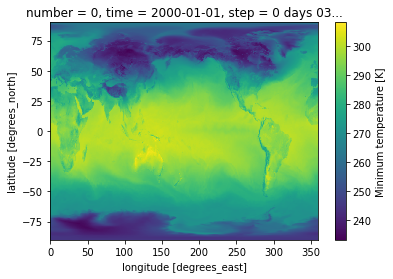

In [11]:
cfg_cc.tmin.sel(step='03:00:00').plot()

# Experiment with PyNIO and PyNGL - only UX systems - no Windows

We discover we can import grib2 file into xarray using engine='pynio'.  This is great because I couldn't figure out how to use engine='cfgrib' above, and for slicing this data into specific lat/lon bin, I would prefer working with xarray.  However temperature is parsed (ie two data arrays) into the 3-hour forecasts and 6-hour forecasts.  We come up with a way to merge these back into a single xarray for the dataset.  Good stuff!

In [11]:
import numpy
import Nio
import Ngl

open file with new name as I think by following the cells in the notebook it's locked by reading above

In [13]:
# URL of AWS S3 Explorer: https://noaa-gefs-retrospective.s3.amazonaws.com/index.html#GEFSv12/reforecast/2000/2000010200/c00/Days:1-10/
url = 'https://noaa-gefs-retrospective.s3.amazonaws.com/GEFSv12/reforecast/2000/2000010100/c00/Days:1-10/tmin_2m_2000010100_c00.grib2'
# Using urllib
urllib.request.urlretrieve(url, 'pynio_tmin_2m_2000010100_c00.grib2')


('pynio_tmin_2m_2000010100_c00.grib2',
 <http.client.HTTPMessage at 0x7fc9366e2610>)

In [15]:
file = Nio.open_file('pynio_tmin_2m_2000010100_c00.grib2', 'r')

# Problems with multiple dimensions for time
Note belowe as each forecast is in it own variable, the time dimension has to have different names, I think this is the issue with useing cfgrib (maybe). This issue comes up repeatedly in these NOAA climate datasets.  Saw the same thing with CFS and GFS data.  THere is probably a good reason why it has to be that way but it makes processing way more difficult.  

* One reason for the splitting of 3h and 6h forecasts might have to do with precip where 3h is accumulated over 3 hours and 6h is accumulated over 6 hours, so if you wanted to integrate to daily values you wouldn't necessarily want 3h-6h concated into single file? 

In [22]:
print(file)

Nio file:	pynio_tmin_2m_2000010100_c00.grib2
   global attributes:
   dimensions:
      forecast_time0 = 40
      lat_0 = 721
      lon_0 = 1440
      forecast_time1 = 40
   variables:
      float TMIN_P11_L103_GLL0_min6h [ forecast_time0, lat_0, lon_0 ]
         center :	US National Weather Service - NCEP (WMC)
         production_status :	Operational products
         long_name :	Minimum temperature
         units :	K
         _FillValue :	1e+20
         grid_type :	Latitude/longitude
         parameter_discipline_and_category :	Meteorological products, Temperature
         parameter_template_discipline_category_number :	[11, 0, 0, 5]
         level_type :	Specified height level above ground (m)
         level :	2
         type_of_statistical_processing :	Minimum
         statistical_process_duration :	6 hours (ending at forecast time)
         initial_time :	01/01/2000 (00:00)
      float TMIN_P11_L103_GLL0_min3h [ forecast_time1, lat_0, lon_0 ]
         center :	US National Weather

In [19]:
names = list(file.variables.keys())
names

['TMIN_P11_L103_GLL0_min6h',
 'TMIN_P11_L103_GLL0_min3h',
 'forecast_time1',
 'lat_0',
 'lon_0',
 'forecast_time0']

In [20]:
print("\nThe attributes and their values for variable {}:".format(names[1]))
for attrib in file.variables[names[1]].attributes.keys():
  t = getattr(file.variables[names[1]],attrib)
  print("Attribute '{}' has value:{}".format(attrib, t))



The attributes and their values for variable TMIN_P11_L103_GLL0_min3h:
Attribute 'center' has value:US National Weather Service - NCEP (WMC)
Attribute 'production_status' has value:Operational products
Attribute 'long_name' has value:Minimum temperature
Attribute 'units' has value:K
Attribute '_FillValue' has value:[1.e+20]
Attribute 'grid_type' has value:Latitude/longitude
Attribute 'parameter_discipline_and_category' has value:Meteorological products, Temperature
Attribute 'parameter_template_discipline_category_number' has value:[11  0  0  5]
Attribute 'level_type' has value:Specified height level above ground (m)
Attribute 'level' has value:[2.]
Attribute 'type_of_statistical_processing' has value:Minimum
Attribute 'statistical_process_duration' has value:3 hours (ending at forecast time)
Attribute 'initial_time' has value:01/01/2000 (00:00)


In [21]:
#
#  For variable in names[1], retrieve and print the dimension names.
#
print("\nFor variable {} the dimension names are:".format(names[1]))
print(file.variables[names[1]].dimensions)



For variable TMIN_P11_L103_GLL0_min3h the dimension names are:
('forecast_time1', 'lat_0', 'lon_0')


# USE engine='pynio' with xarray
AHA!  Reads simply with no errors.  However there is still the issue of multiple time coordinates with makes it difficult to merge these dataarrays.

In [ ]:
ds2 = xr.open_dataset('tmin_2m_2000010100_c00.grib2', engine='pynio')
ds2

# Experiment: 
* Parse 3h and 6h variables into seperate datasets, rename time dimension and coordinate to be the same 'time' and then concat into one file!  The result is a single xarray with variable tmin, at a time step of 3 hours

In [117]:
ds_3h = ds2.TMIN_P11_L103_GLL0_min3h.to_dataset(name='tmin')
print(ds_3h)
# ds_3h.reset_index('forecast_time1')
# ds_3h.reset_coords()

# ds_3h.rename_vars({'TMIN_P11_L103_GLL0_min3h':'tmin'})
ds_3h = ds_3h.rename_dims({'forecast_time1':'time'})
ds_3h = ds_3h.rename({'forecast_time1':'time'})
ds_3h

<xarray.Dataset>
Dimensions:         (forecast_time1: 40, lat_0: 721, lon_0: 1440)
Coordinates:
  * forecast_time1  (forecast_time1) timedelta64[ns] 0 days 03:00:00 ... 9 da...
  * lat_0           (lat_0) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon_0           (lon_0) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
Data variables:
    tmin            (forecast_time1, lat_0, lon_0) float32 ...


<xarray.Dataset>
Dimensions:  (lat_0: 721, lon_0: 1440, time: 40)
Coordinates:
  * time     (time) timedelta64[ns] 0 days 03:00:00 ... 9 days 21:00:00
  * lat_0    (lat_0) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * lon_0    (lon_0) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.25 359.5 359.75
Data variables:
    tmin     (time, lat_0, lon_0) float32 ...

In [118]:
ds_6h = ds2.TMIN_P11_L103_GLL0_min6h.to_dataset(name='tmin')
# ds_6h = ds_6h.reset_index('forecast_time0')
# ds_6h = ds_6h.reset_coords()
# ds_6h.rename_vars({'TMIN_P11_L103_GLL0_min6h':'tmin'})
ds_6h = ds_6h.rename_dims({'forecast_time0':'time'})
ds_6h = ds_6h.rename({'forecast_time0':'time'})
ds_6h

<xarray.Dataset>
Dimensions:  (lat_0: 721, lon_0: 1440, time: 40)
Coordinates:
  * lat_0    (lat_0) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * lon_0    (lon_0) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.25 359.5 359.75
  * time     (time) timedelta64[ns] 0 days 06:00:00 ... 10 days 00:00:00
Data variables:
    tmin     (time, lat_0, lon_0) float32 ...

In [123]:
ds_cc = xr.concat([ds_3h, ds_6h], dim='time')
# ds_cc = xr.combine_by_coords()

In [124]:
ds_cc

<xarray.Dataset>
Dimensions:  (lat_0: 721, lon_0: 1440, time: 80)
Coordinates:
  * time     (time) timedelta64[ns] 0 days 03:00:00 ... 10 days 00:00:00
  * lat_0    (lat_0) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * lon_0    (lon_0) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.25 359.5 359.75
Data variables:
    tmin     (time, lat_0, lon_0) float32 263.44 263.44 ... 244.21869 244.21869

In [126]:
ds_cc.to_netcdf('test.nc')

In [128]:
ds_cc.lat_0.attrs

{'long_name': 'latitude',
 'grid_type': 'Latitude/Longitude',
 'units': 'degrees_north',
 'Dj': array([0.25], dtype=float32),
 'Di': array([0.25], dtype=float32),
 'Lo2': array([359.75], dtype=float32),
 'La2': array([-90.], dtype=float32),
 'Lo1': array([0.], dtype=float32),
 'La1': array([90.], dtype=float32)}

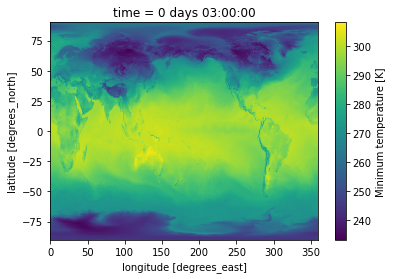

In [135]:
ds_cc.tmin.sel(time='03:00:00').plot()